# Leitura dos Dados 

In [79]:
import pandas as pd
import numpy as np
from pyunicorn import climate
import netCDF4 as nc
from datetime import datetime

In [80]:
fp = '../air.mon.mean.nc'

ds = nc.Dataset(fp)
print(ds)
tempo = ds.variables['time'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    Re

In [81]:
ds.variables['lon'][:]

masked_array(data=[  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,
                    20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
                    40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
                    60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
                    80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
                   100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
                   120. , 122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5,
                   140. , 142.5, 145. , 147.5, 150. , 152.5, 155. , 157.5,
                   160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
                   180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
                   200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5,
                   220. , 222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5,
                   240. , 242.5, 245. , 247.5, 250. , 252.5, 255. , 257.5,
                   260. ,

4-times daily, daily and monthly values for 1948/01 to 2022/09

# Criando nossas redes complexas

Passo a passo:
+ Ler o arquivo usando o pyunicorn para conseguir usar os métodos presente nele
+ Remover de cada observação (mês) a média de toda série histórica daquele mês
+ Criar uma rede complexa para cada 12 meses subsequentes na série temporal baseado no coeficiente de correlação de Pearson, ou seja, através de uma *sliding window* (método onde vamos deslizando no eixo do tempo o intervalo estudado, então se o ponto inicial for o mês 10/2000 a janela começara em 10/1999, a próxima jenela então será [11/1999 **:** 11/2000]) vamos calcular o coeficiente de correlação entre todas as séries temporais de cada nó no globo, assim aquelas que tiverem a correlação acima do *threshold**, atribuiremos um *link* entre elas.
+ Para cada **CN** (*Complex Network*) vamos calcular algumas métricas:
    + **Characterization of the temporal networks according to the adopted topological measures, transitivity (τ), modularity (Q), average degree (hki),
the number of links (M), global average link distance (hhdii), and the averages of Coreness (Co), Eigenvector (Ev) centralities,
Eccentricity (Ec), and shortest-path length (h`i).**




**Segundo [Classifying El Niño-Southern Oscillation Combining Network Science and Machine Learning](https://ieeexplore.ieee.org/abstract/document/9042254) o artigo esse valor foi estipulado por outros estudos relacionados*

# Pyunicorn para trazer os dados e gerar as CN

In [82]:
tempo.shape[0]

897

In [323]:
daterange = pd.date_range('1948-01-10', '2022-10-10' , freq='1M') 
daterange = [d.strftime('%b-%y') for d in daterange]
print("total de mêses: ", len(daterange))
print(daterange[:5])
print(daterange[-5:])

total de mêses:  897
['Jan-48', 'Feb-48', 'Mar-48', 'Apr-48', 'May-48']
['May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22']


In [324]:
#  Settings
#

#  Related to data

#  Path and filename of NetCDF file containing climate data
DATA_FILENAME = '../air.mon.mean.nc'

#  Type of data file ("NetCDF" indicates a NetCDF file with data on a regular
#  lat-lon grid, "iNetCDF" allows for arbitrary grids - > see documentation).
#  For example, the "NetCDF" FILE_TYPE is compatible with data from the IPCC
#  AR4 model ensemble or the reanalysis data provided by NCEP/NCAR.
FILE_TYPE = "NetCDF"

#  Indicate data source (optional)
DATA_SOURCE = "ncep_ncar_reanalysis"

#  Name of observable in NetCDF file ("air" indicates surface air temperature
#  in NCEP/NCAR reanalysis data)
OBSERVABLE_NAME = "air"

#  Select a subset in time and space from the data (e.g., a particular region
#  or a particular time window, or both)
WINDOW = {"time_min": 0., "time_max": 0., "lat_min": -65., "lon_min": 0.,
          "lat_max": 65., "lon_max": 357.5} # selects the whole data set

#  Indicate the length of the annual cycle in the data (e.g., 12 for monthly
#  data). This is used for calculating climatological anomaly values
#  correctly.
TIME_CYCLE = 12

#  Related to climate network construction

#  For setting fixed threshold -> Threshould obtido de trabalhos relacionados
THRESHOLD = 0.65 

#  For setting fixed link density
LINK_DENSITY = 0.005

#  Indicates whether to use only data from winter months (DJF) for calculating
#  correlations
WINTER_ONLY = False

#
#  Print script title
#

print("\n")
print("Tutorial on how to use climate")
print("-------------------------------")
print("\n")

#
#  Create a ClimateData object containing the data and print information
#

data = climate.ClimateData.Load(
    file_name=DATA_FILENAME, observable_name=OBSERVABLE_NAME,
    data_source=DATA_SOURCE, file_type=FILE_TYPE,
    window=WINDOW, time_cycle=TIME_CYCLE)



Tutorial on how to use climate
-------------------------------


Reading NetCDF File and converting data to NumPy array...


In [267]:
data.observable().shape

(897, 7632)

In [325]:
# To obtain climatological anomaly time series, the climatological means are subtracted from each sample in the original time series. This procedure is also known as phase averaging.

data_off_annomalys = data._calculate_anomaly()

Calculating daily (monthly) anomaly values...


In [89]:
def metrics(CN):
   # Link density
   start = datetime.now()
   link_density =  CN.link_density # measure
   end = datetime.now()
   print("Link desnsity:", end-start)
   
   #  Get degree
   start = datetime.now()
   degree = CN.degree().mean() #list
   end = datetime.now()
   print("degree:", end-start)

   #  Get closeness
   start = datetime.now()
   closeness = CN.closeness().mean() #list
   end = datetime.now()
   print("closeness:", end-start)

   #  Get betweenness
   start = datetime.now()
   betweenness = CN.betweenness().mean() #list
   end = datetime.now()
   print("betweennes:", end-start)

   #  Get local clustering coefficient
   start = datetime.now()
   clustering = CN.local_clustering().mean() #list
   end = datetime.now()
   print("clustering:", end-start)

   #  Get average link distance
   start = datetime.now()
   ald = CN.average_link_distance().mean() #list
   end = datetime.now()
   print("ald:", end-start)

   #  Get maximum link distance
   start = datetime.now()
   mld = CN.max_link_distance().max() #list
   end = datetime.now()
   print("mld:", end-start)

   # Return the average (weighted) shortest path length between all pairs of nodes for which a path exists.
   start = datetime.now()
   L = CN.average_path_length()
   end = datetime.now()
   print("L:", end-start)

   
   # Return the transitivity (coefficient).
   start = datetime.now()
   T = CN.transitivity()
   end = datetime.now()
   print("T:", end-start)


   # Return the global (Watts-Strogatz) clustering coefficient.
   start = datetime.now()
   C = CN.global_clustering()
   end = datetime.now()
   print("C:", end-start)

   # Return the assortativity coefficient.
   start = datetime.now()
   R = CN.assortativity()
   end = datetime.now()
   print("R:", end-start)


   # For each node, return the average degree of its neighbors.
   start = datetime.now()
   knn = CN.average_neighbors_degree().mean() #list
   end = datetime.now()
   print("knn:", end-start)


   # For each node, return its coreness.
   start = datetime.now()
   k_core = CN.coreness().mean() #list
   end = datetime.now()
   print("k core:", end-start)

   # Return the diameter (largest shortest path length between any nodes).
   start = datetime.now()
   d = CN.diameter() 
   end = datetime.now()
   print("d:", end-start)


   # For each node, return its eigenvector centrality.
   start = datetime.now()
   Ev = CN.eigenvector_centrality().mean() #list
   end = datetime.now()
   print("Ev:", end-start)


   # Return the global (weighted) efficiency
   start = datetime.now()
   E = CN.global_efficiency()
   end = datetime.now()
   print("E:", end-start) 


   # For each node, return Newman’s random walk betweenness.
   #newman_betweennes = net.newman_betweenness()


   # For each node, return its (weighted) PageRank.
   start = datetime.now()
   page_rank = CN.pagerank().mean() #list
   end = datetime.now()
   print("page rank:", end-start)

   metrics_ = {"link_density": link_density, "k": degree, "closeness": closeness, "link_dist": ald,
   "max_link_dist": mld, "L":L, "T":T, "C":C, "R":R, "knn":knn, "k-core":k_core, "d":d, "Ev":Ev, "Efficiency": E, "page-rank": page_rank}
   
   return metrics_

In [114]:
lista = []

Spatial Coverage
* 2.5 degree x 2.5 degree global grids (144x73)
* 0.0E to 357.5E, 90.0N to 90.0S
* Some variables are stored as spectral coefficients

In [120]:
def sliding_window(ds, timeline, range_window, daterange, threshould, anomaly):

    #df = pd.DataFrame(columns=["link_density", "k", "closeness", "link_dist",
    #"max_link_dist", "L", "T", "C", "R", "knn", "k-core", "d", "Ev", "Efficiency", "page-rank"])
    
    # começa na obs time 13 (1 ano e 1 mês para calc. corr.)
    for mes in np.arange(range_window, 98):
      
      # ajustamos a janela para aquele intervalo
      WINDOW_ = {"time_min": timeline[mes-range_window], "time_max": timeline[mes-1], "lat_min": -65., "lon_min": 0.,
        "lat_max": 65., "lon_max": 357.5}
      ds.set_window(WINDOW_)

      # removendo média
      ds.observable()[:] = anomaly[mes-range_window:mes]

      # criamos a CN
      start = datetime.now()
      
      net = climate.TsonisClimateNetwork(
        ds, threshold=threshould, winter_only=False)
      
      end = datetime.now()
      print("\nConstrução Complex Network: {}/{}\t #{}#".format(daterange[mes-range_window], daterange[mes], end-start))


      metrics_ = metrics(net)
      metrics_["mes-ano"] = daterange[mes]
      
      lista.append(metrics_)
      
    
    return lista

In [116]:
lista_ = sliding_window(data, tempo, 18, daterange, THRESHOLD, data_off_annomalys)

Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...

Construção Complex Network: Jan-48/Jul-49	 #0:00:23.213508#
Link desnsity: 0:00:00
degree: 0:00:00.000998
Calculating closeness...
closeness: 0:03:43.259781
Calculating node betweenness...
betweennes: 0:10:53.543827
Calculating local clustering coefficients...
clustering: 0:01:09.391131
Calculating average link distance...
Calculating angular great circle distance using Cython...
ald: 0:00:14.798618
Calculating maximum link distance...
mld: 0:00:06.992280
Calculating average (weighted) shortest path length...
L: 0:07:12.117289
Calculating transitivity coefficient (C_1)...
T: 0:01:56.944496
Calculating global clustering coefficient (C_2)...
C: 0:00:00.008006
R: 0:00:06.083821
Calcula

In [121]:
lista_metricas_redes = lista.copy()
lista1_bkp = lista.copy()

In [123]:
lista2_ = sliding_window(data, tempo, 18, daterange, THRESHOLD, data_off_annomalys)
lista_metricas_redes2 = lista.copy()
lista2_bkp = lista.copy()

Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...

Construção Complex Network: Mar-52/Sep-53	 #0:00:16.887711#
Link desnsity: 0:00:00
degree: 0:00:00
Calculating closeness...
closeness: 0:03:48.225119
Calculating node betweenness...
betweennes: 0:03:01.382949
Calculating local clustering coefficients...
clustering: 0:00:08.600927
Calculating average link distance...
Calculating angular great circle distance using Cython...
ald: 0:00:01.706895
Calculating maximum link distance...
mld: 0:00:00.817056
Calculating average (weighted) shortest path length...
L: 0:00:55.408751
Calculating transitivity coefficient (C_1)...
T: 0:00:13.095570
Calculating global clustering coefficient (C_2)...
C: 0:00:00
R: 0:00:02.478172
Calculating average n

In [190]:
len(lista)

80

In [250]:
df = pd.DataFrame(columns=["link_density", "k", "closeness", "link_dist",
 "max_link_dist", "L", "T", "C", "R", "knn", "k-core", "d", "Ev", "Efficiency", "page-rank", "mes-ano"])

In [193]:
lista1_bkp

[{'link_density': 0.1388921169223956,
  'k': 1059.8857442348008,
  'closeness': 0.5368767277381142,
  'link_dist': 1.4330989600595212,
  'max_link_dist': 3.1415927,
  'L': 1.8635249590177108,
  'T': 0.4619623774838563,
  'C': 0.452762948578716,
  'R': 0.4978812988749807,
  'knn': 1100.6539345088754,
  'k-core': 574.5638102725367,
  'd': 3,
  'Ev': 0.36844644956196454,
  'Efficiency': 0.5690432124711792,
  'page-rank': 0.00013102725366876308,
  'mes-ano': 'Jul-49'},
 {'link_density': 0.13650313174195403,
  'k': 1041.6553983228512,
  'closeness': 0.5361470136395906,
  'link_dist': 1.4371172847688622,
  'max_link_dist': 3.1415927,
  'L': 1.8660611631305277,
  'T': 0.4644492549081813,
  'C': 0.4518234070383865,
  'R': 0.5314436586071802,
  'knn': 1080.5156711603674,
  'k-core': 573.8249475890985,
  'd': 3,
  'Ev': 0.34043188082332854,
  'Efficiency': 0.5678241833922306,
  'page-rank': 0.0001310272536687631,
  'mes-ano': 'Aug-49'},
 {'link_density': 0.14927254547887123,
  'k': 1139.09879454

In [126]:
lista2_bkp

[{'link_density': 0.1388921169223956,
  'k': 1059.8857442348008,
  'closeness': 0.5368767277381142,
  'link_dist': 1.4330989600595212,
  'max_link_dist': 3.1415927,
  'L': 1.8635249590177108,
  'T': 0.4619623774838563,
  'C': 0.452762948578716,
  'R': 0.4978812988749807,
  'knn': 1100.6539345088754,
  'k-core': 574.5638102725367,
  'd': 3,
  'Ev': 0.36844644956196454,
  'Efficiency': 0.5690432124711792,
  'page-rank': 0.00013102725366876308,
  'mes-ano': 'Jul-49'},
 {'link_density': 0.13650313174195403,
  'k': 1041.6553983228512,
  'closeness': 0.5361470136395906,
  'link_dist': 1.4371172847688622,
  'max_link_dist': 3.1415927,
  'L': 1.8660611631305277,
  'T': 0.4644492549081813,
  'C': 0.4518234070383865,
  'R': 0.5314436586071802,
  'knn': 1080.5156711603674,
  'k-core': 573.8249475890985,
  'd': 3,
  'Ev': 0.34043188082332854,
  'Efficiency': 0.5678241833922306,
  'page-rank': 0.0001310272536687631,
  'mes-ano': 'Aug-49'},
 {'link_density': 0.14927254547887123,
  'k': 1139.09879454

[ONI](C:\Users\lagee\OneDrive\Documentos\USP\Prática em Ciência da Dados\Classificando El Niño Southern Oscillation\ONI.img)

Region of the El Niño3.4 considered for the ONI index, delimited from latitude 5◦N to 5◦S and from longitude 170◦W to 120◦W
(to pyunicorn: lat: -5° to 5° & lon: 190° to 240°)

In [244]:
ONI_RANGE = WINDOW_ = {"time_min": 0., "time_max": 0., "lat_min": -5., "lon_min": 190.,
        "lat_max": 5., "lon_max": 240.}

data_ONI_window = climate.ClimateData.Load(
    file_name=DATA_FILENAME, observable_name=OBSERVABLE_NAME,
    data_source=DATA_SOURCE, file_type=FILE_TYPE,
    window=ONI_RANGE, time_cycle=TIME_CYCLE)

Reading NetCDF File and converting data to NumPy array...


In [245]:
data_off_annomalys_ONI = data_ONI_window._calculate_anomaly()

Calculating daily (monthly) anomaly values...


In [246]:
data_off_annomalys_ONI.shape

(897, 105)

In [248]:
lista_ONI = []

In [242]:
def sliding_window_ONI_range(ds, timeline, range_window, daterange, anomaly):

    
    # começa na obs time 13 (1 ano e 1 mês para calc. corr.)
    for mes in np.arange(range_window, 98):
      
      # ajustamos a janela para aquele intervalo
      WINDOW_ = {"time_min": timeline[mes-range_window+1], "time_max": timeline[mes-range_window+3], "lat_min": -5., "lon_min": 190.,
        "lat_max": 5., "lon_max": 240.}
      ds.set_window(WINDOW_)

      # removendo média
      ds.observable()[:] = anomaly[mes-range_window:mes-range_window+3]

      ONI_ = ds.observable()[:].mean()
      
      lista_ONI.append({"ONI": ONI_, "mes-ano": daterange[mes]})

    return lista

In [249]:
lista_ONI_ = sliding_window_ONI_range(data_ONI_window, tempo, 18, daterange, data_off_annomalys_ONI)

In [180]:
len(lista1_bkp), len(lista2_bkp)

(130, 80)

In [224]:
len(df[df.duplicated() == True])

50

In [225]:
lista2_bkp_bkp = lista2_bkp.copy()

In [251]:
for i in lista2_bkp:
    df = df.append(i, ignore_index=True)

In [252]:
df_oni = pd.DataFrame(columns=["ONI", "mes-ano"])
for j in lista_ONI:
    df_oni = df_oni.append(j, ignore_index=True)

df = df.merge(df_oni, left_on="mes-ano", right_on="mes-ano")

In [253]:
df

,link_density,k,closeness,link_dist,max_link_dist,L,T,C,R,knn,k-core,d,Ev,Efficiency,page-rank,mes-ano,ONI
0,0.138892,1059.885744,0.536877,1.433099,3.141593,1.863525,0.461962,0.452763,0.497881,1100.653935,574.563810,3,0.368446,0.569043,0.000131,Jul-49,-0.307215
1,0.136503,1041.655398,0.536147,1.437117,3.141593,1.866061,0.464449,0.451823,0.531444,1080.515671,573.824948,3,0.340432,0.567824,0.000131,Aug-49,-0.362405
2,0.149273,1139.098795,0.540085,1.450108,3.141593,1.853072,0.486708,0.471811,0.517850,1200.527500,615.331630,3,0.335549,0.574246,0.000131,Sep-49,-0.440912
3,0.157517,1202.009958,0.542852,1.471339,3.141593,1.844567,0.505046,0.478530,0.539335,1287.293424,658.505503,3,0.320051,0.578411,0.000131,Oct-49,-0.420933
4,0.157378,1200.949686,0.542871,1.488161,3.141593,1.844436,0.502575,0.475150,0.542344,1284.807372,652.134565,3,0.322875,0.578387,0.000131,Nov-49,-0.397324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.168770,1287.881289,0.546401,1.466293,3.141593,1.833483,0.533652,0.495891,0.548539,1392.936303,711.656447,3,0.333020,0.584009,0.000131,Oct-55,-0.411792
76,0.159745,1219.017296,0.543521,1.458972,3.141593,1.842034,0.502838,0.480837,0.520486,1300.924724,653.493580,3,0.348438,0.579576,0.000131,Nov-55,-0.559091
77,0.160000,1220.960168,0.543579,1.432589,3.141593,1.842049,0.514594,0.484896,0.547856,1303.721630,662.541798,3,0.338557,0.579659,0.000131,Dec-55,-0.699031
78,0.158571,1210.054769,0.542930,1.410263,3.141593,1.843839,0.506369,0.486469,0.525274,1283.606399,650.111766,3,0.345853,0.578884,0.000131,Jan-56,-0.758946


In [254]:
df.describe()

,link_density,k,closeness,link_dist,max_link_dist,L,T,C,R,knn,k-core,Ev,Efficiency,page-rank,ONI
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,8.000000e+01,80.000000
mean,0.166306,1269.081414,0.545673,1.455822,3.141593,1.836399,0.533914,0.494536,0.554174,1367.089847,712.175858,0.340563,0.582702,1.310273e-04,-0.394713
std,0.021104,161.041803,0.006956,0.024239,0.000000,0.020717,0.050710,0.030370,0.035519,200.541221,113.751770,0.026022,0.010486,3.409508e-20,0.383303
min,0.133168,1016.203878,0.535423,1.386382,3.141593,1.772437,0.455113,0.440492,0.461493,1053.672631,547.280398,0.300661,0.566303,1.310273e-04,-1.194122
25%,0.151598,1156.843619,0.540909,1.442097,3.141593,1.828926,0.497869,0.474893,0.528698,1228.825846,636.833268,0.323366,0.575424,1.310273e-04,-0.676192
50%,0.162101,1236.993056,0.544206,1.458636,3.141593,1.840441,0.522775,0.487329,0.552848,1328.614521,680.033936,0.333864,0.580668,1.310273e-04,-0.376514
75%,0.173690,1325.430556,0.547970,1.471389,3.141593,1.850733,0.560404,0.509745,0.579214,1438.997599,750.975334,0.348740,0.586403,1.310273e-04,-0.074044
max,0.231160,1763.985587,0.567946,1.512043,3.141593,1.868520,0.661677,0.576497,0.630892,1981.872157,1085.227332,0.430682,0.614981,1.310273e-04,0.218170


In [256]:
Ev = net.eigenvector_centrality()

In [265]:
Ev

array([1., 1., 1., ..., 1., 1., 1.])

<AxesSubplot:>

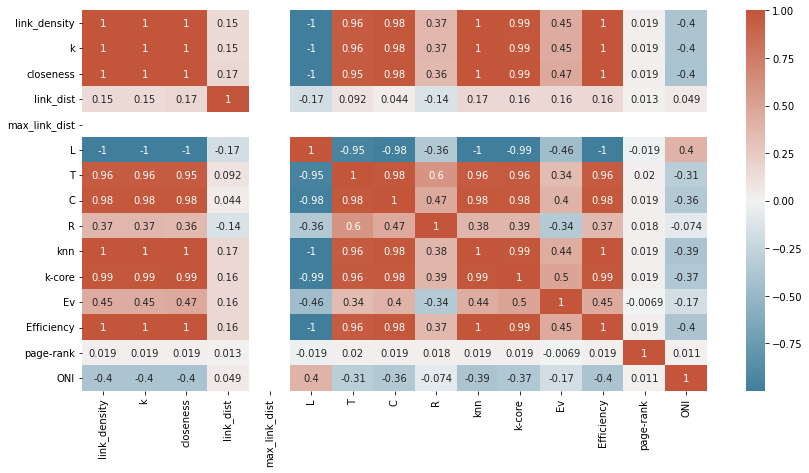

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (14,7))
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot = True, cmap = cmap)

Vamos dropar as variáveis constantes: **page-rank** e **max-link-distance** 

In [297]:
df2 = df.drop(columns=["page-rank", "max_link_dist"])

In [331]:
def sliding_window(ds, timeline, range_window, daterange, threshould, anomaly):

    #df = pd.DataFrame(columns=["link_density", "k", "closeness", "link_dist",
    #"max_link_dist", "L", "T", "C", "R", "knn", "k-core", "d", "Ev", "Efficiency", "page-rank"])
    
    # começa na obs time 13 (1 ano e 1 mês para calc. corr.)
    for mes in np.arange(range_window, 98):
      
      # ajustamos a janela para aquele intervalo
      WINDOW_ = {"time_min": timeline[mes-range_window], "time_max": timeline[mes-1], "lat_min": -65., "lon_min": 0.,
        "lat_max": 65., "lon_max": 357.5}
      ds.set_window(WINDOW_)

      # removendo média
      ds.observable()[:] = anomaly[mes-range_window:mes]

      # criamos a CN
      start = datetime.now()
      
      net = climate.TsonisClimateNetwork(
        ds, threshold=threshould, winter_only=False)
      
      end = datetime.now()
      print("Construção Complex Network: {}/{}\t #{}#\n".format(daterange[mes-range_window], daterange[mes], end-start))

      betweenness = net.betweenness().mean() 
      #metrics_ = metrics(net)
      
      
      lista_betweeness.append(betweenness)
      
    
    return lista

In [332]:
lista_betweeness = list()
lista_betweeness_ = sliding_window(data, tempo, 18, daterange, THRESHOLD, data_off_annomalys)

Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...
Construção Complex Network: Jan-48/Jul-49	 #0:00:19.979698#

Calculating node betweenness...
Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...
Construção Complex Network: Feb-48/Aug-49	 #0:00:18.194132#

Calculating node betweenness...
Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by threshol

In [333]:
lista_betweeness_bkp = lista_betweeness.copy

## PCA

Primeiramente precisamos padronizar os dados

In [335]:
lista_betweeness

[3294.7794811320746,
 3304.4563679245275,
 3254.8955712788256,
 3222.445099580712,
 3221.944182389936,
 3242.6281446540875,
 3223.993448637316,
 3257.2362421383646,
 3250.37788259958,
 3244.927935010482,
 3247.8920335429766,
 3266.7037473794544,
 3245.3321540880497,
 3209.7333595387836,
 3177.3238993710693,
 3170.708726415094,
 3162.965932914045,
 3197.9318658280913,
 3205.417583857442,
 3199.088181341719,
 3206.760089098532,
 3191.5837264150937,
 3197.1336477987415,
 3206.6447851153034,
 3173.8242924528304,
 3169.100759958071,
 3071.7763364779876,
 3027.5169025157234,
 3059.595649895178,
 3062.9095911949685,
 3035.856394129979,
 3006.3043763102723,
 2985.8098794549264,
 2947.2351939203354,
 2979.006682389937,
 3076.0488731656183,
 3162.1671907756813,
 3214.905267295597,
 3242.554376310272,
 3270.783018867924,
 3274.567610062892,
 3227.1280136268338,
 3135.846174004193,
 3140.8248165618447,
 3168.5323637316556,
 3195.0995807127874,
 3228.38430293501,
 3263.3848270440244,
 3313.83700209

In [301]:
from sklearn.preprocessing import StandardScaler

# selecionando as features

X = df2.drop(columns=["ONI", "mes-ano"])
X_feats = X.columns
X = X.values

# selecionando a target
y = df2.ONI

# Standardize
X_stand = StandardScaler().fit_transform(X)

In [303]:
y_labels = y.apply(lambda x: "La Nina" if x < -0.5 else "El Nino" if x > 0.5 else "AE")

In [304]:
from sklearn.decomposition import PCA

covar_matrix = PCA(n_components=len(X_feats))
covar_matrix.fit(X_stand)

PCA(n_components=13)

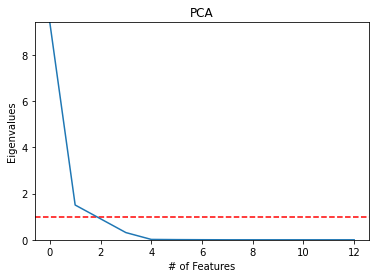

In [306]:
plt.ylabel("Eigenvalues")
plt.xlabel("# of Features")
plt.title("PCA")
plt.ylim(0, max(covar_matrix.explained_variance_))
plt.axhline(y=1, color="red", linestyle="--")
plt.plot(covar_matrix.explained_variance_)

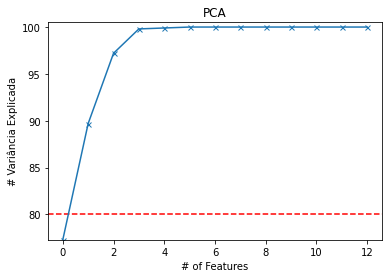

In [313]:
variancia = covar_matrix.explained_variance_
var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
plt.ylabel("# Variância Explicada")
plt.xlabel("# of Features")
plt.title("PCA")
plt.ylim(min(var), 100.5)
plt.axhline(y=80, color="red", linestyle="--")
plt.plot(var, marker="x", markersize=5)

Portanto para apenas 2 componentes, conseguimos explicar cerca de 97.5% da variância dos dados

In [315]:
# Set the n_components=2
principal=PCA(n_components=2)
principal.fit(X_stand)
X_pca=principal.transform(X_stand)

Text(0, 0.5, 'pc2')

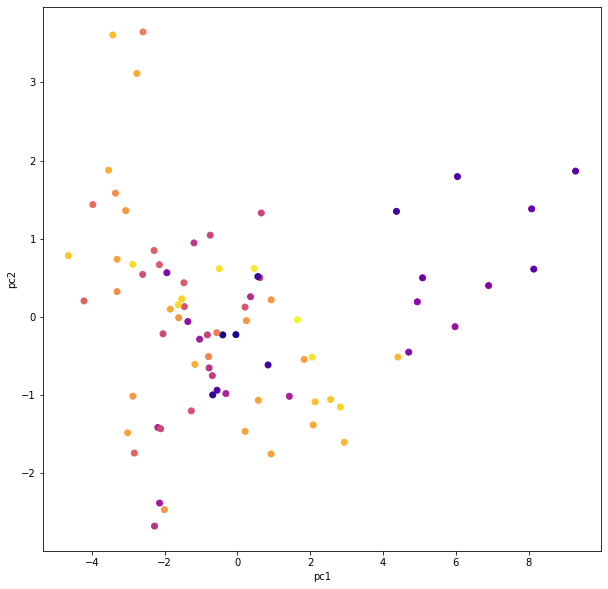

In [318]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC2')

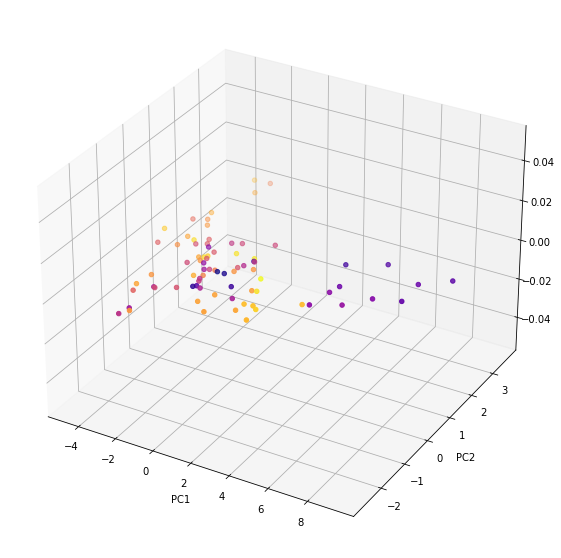

In [320]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)